#  High Dynamic Range

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io, transform, color, filters
import random
import glob

In [52]:
# project goals
# 1. write software to automatically combine multiple exposures into a single high dynamic range radiance map
# 2. convert this radiance map to an image suitable for display through tone mapping

##  Load images

In [53]:
Hi glenn, good morning!
Not  sure what needs to go in the write up but thise code works for all the images in
the data folder, i havent written or saved outputs yet but yeah just run all and it  should  works
------ morgan :D

SyntaxError: invalid syntax (<ipython-input-53-7222f5828e4e>, line 1)

In [113]:
#load in the images
PATH = "data/garden/*"
image_path = glob.glob(PATH, recursive = True)
#memorial_txt =  np.genfromtxt(PATH+'memorial.hdr_image_list.txt', skip_header=3, dtype = str)

In [114]:
def get_exposure(string):
    index = string.index('_')
    num = 0
    denom = 0

    try:
        num = int(string[index-2:index])
    except:
        num = int(string[index-1:index])

    denom = int(string[index+1:-4])

    return num/denom

In [115]:
grey_images = []
color_images = []
exposure_length = []
for im_path in image_path:
    
    grey_im = cv2.imread(im_path,0)
    color_im = io.imread(im_path)
    grey_images.append(grey_im)
    color_images.append(color_im)
    
    exposure_length.append(get_exposure(im_path))
    
grey_images = np.asarray(grey_images)
color_images = np.asarray(color_images)
exposure_length = np.asarray(exposure_length, dtype = np.float64)
log_ex = np.log(exposure_length)

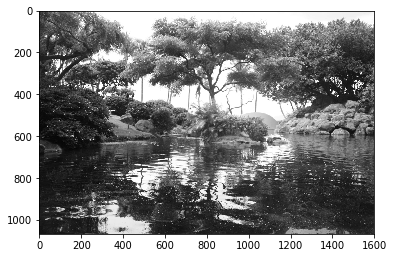

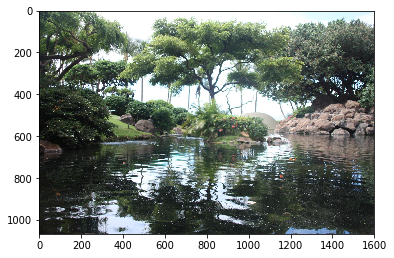

0.003125


In [116]:
index = 2
plt.rcParams['figure.figsize'] = [6, 6]
plt.imshow(grey_images[index],cmap = "gray")
plt.show()
plt.imshow(color_images[index])
plt.show()
print(exposure_length[index])

## Film Response Recovery (2.1 from Debevec and Makil 1997)

In [117]:
# only want to do comutated on a a sample size of the image
#  pixel locations should be chosen so that they have a reasonably even distribution 
    # of pixel values from Zmin (0) to Zmax (255
def sample_images(Z):
    
    #define middle im to locate intensities
    mid_index = Z.shape[0] // 2
    indexs = []
    im_values = np.zeros((256, Z.shape[0]))
    
    
    #loop through each intensity and find a pixel that matches
    for i in range(256):
        r, c = np.asarray(Z[mid_index] == i).nonzero()
        if len(r) != 0:
            randint = np.random.randint(0, len(r), 1)
            
            for j in range(Z.shape[0]):
                im_values[i][j] = Z[j][r[randint], c[randint]]

    
    #return 255 samples
    return im_values

In [118]:
sample_im = sample_images(grey_images)

In [120]:
# eqn (4) in paper
# used to emphasize terms towards the middle of the curve
def weight_func(intensity):
    if intensity <= (255 / 2):
        return intensity
    return 255 - intensity

In [121]:
#create response curve (ADAPTED FROM CODE IN APPENDIX OF PAPER)

# Z: sample intensities
# B: log of exposure
# l: smoothness constant
# w: weight function

def compute_g(Z, B, l, w):
    
    n = 256
    A = np.zeros((Z.shape[0] * Z.shape[1] + n + 1, n + Z.shape[0]))
    b = np.zeros((A.shape[0], 1))

    #Include the data−fitting equations
    k = 0
    
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
             
            #calculate weight
            wij = w(Z[i, j] + 1)
            
            #calculate A and B
           # print(A.shape)
           # print(k, Z[i,j]+1)
            A[k, int(Z[i, j] + 1)] = wij 
            A[k,n + i] = - wij
            #print(i)
            b[k] = wij * B[j]
            k = k + 1
            
            

    #Fix the curve by setting its middle value to 0

    A[k, 129] = 1
    k = k + 1
    
    # Include the smoothness equations
    for i in range(0, n - 2):
        A[k, i] = l * w(i + 1)
        A[k, i + 1] = -2 * l * w(i + 1)
        A[k, i + 2] = l * w(i + 1)
        k = k + 1;

    #Solve the system using SVD 
    inv_A = np.linalg.pinv(A)
    x = np.dot(inv_A, b)
    g = x[0:n]
    lE = x[n+1:x.shape[0]]
    
    #g: log expsoure corresponding pixel value
    #lE: log film irradiance at pixel location i
    return g, lE

In [122]:
g,le = compute_g(sample_im, log_ex, 100, weight_func)

## Constructing the High Dynamic Range Radiance Map (2.2 from paper)

In [123]:
def construct_map(Z, w, g, B):
    P = Z.shape[0]
    lnE = np.zeros((Z.shape[1], Z.shape[2]))
    
    #for pixel
    for r in range(Z.shape[1]):
        for c in range(Z.shape[2]):
            
            num = 0
            denom = 0

            #sum over all images
            for i in range(P):

                wij = w(Z[i, r, c])
                gij = g[int(Z[i, r, c])]
                b = B[i]
            

                num += (wij * (gij - b))

                denom += wij
            
            if denom < 0:
                print(denom)
            
            lnE[r,c] = num / denom 
    return lnE

## Tone Mapping

In [124]:
# Your input is linear RGB values of radiance.

# Compute the intensity (I) by averaging the color channels.
# Compute the chrominance channels: (R/I, G/I, B/I)
# Compute the log intensity: L = log2(I)
# Filter that with a bilateral filter: B = bf(L)
# Compute the detail layer: D = L - B
# Apply an offset and a scale to the base: B' = (B - o) * s
# The offset is such that the maximum intensity of the base is 1. Since the values are in the log domain, o = max(B).
# The scale is set so that the output base has dR stops of dynamic range, i.e., s = dR / (max(B) - min(B)). Try values between 2 and 8 for dR, that should cover an interesting range. Values around 4 or 5 should look fine.
# Reconstruct the log intensity: O = 2^(B' + D)
# Put back the colors: R',G',B' = O * (R/I, G/I, B/I)
# Apply gamma compression. Without gamma compression the result will look too dark. Values around 0.5 should look fine (e.g. result.^0.5). You can also apply the simple global intensity scaling to your final output.

In [125]:
def avg_channels(im):
    im = color_images[0]
    avg_im = np.zeros(im.shape[:2])
    for x in range(im.shape[0]):
        for y in range(im.shape[1]):
            avg_im[x, y] = np.average(im[x, y, :])
    return avg_im

In [126]:
#simplified implementation of Durand 2002
def tone_mapping(image):
    
        
        # Compute the intensity (I) by averaging the color channels.
        avg_im = avg_channels(image)
        
        # Compute the chrominance channels: (R/I, G/I, B/I)
        chrominance_channels = np.array([image[:,:,i] / avg_im for i in range(3)])
        
        # Compute the log intensity: L = log2(I)
        L = np.log2(avg_im)
        
        # Filter that with a bilateral filter: B = bf(L)
        B = []
        B = cv2.bilateralFilter(L.astype(np.float32), 9,75,75) # 9, 75, 75 seem to be common
        
        print(B)
        print(B.shape)
        # Compute the detail layer: D = L - B
        D = L - B
        
        # Apply an offset and a scale to the base: B' = (B - o) * s
        offset = np.max(B) #o = max(B)
        dR = 5
        scale = dR / (np.max(B) - np.min(B))
        B_prime = (B - offset) * scale
        
        # Reconstruct the log intensity: O = 2^(B' + D)
        O =  2**(B_prime + D)
        
        # Put back the colors: R',G',B' = O * (R/I, G/I, B/I)
        R_prime = O * chrominance_channels[0]
        G_prime = O * chrominance_channels[1]
        B_prime = O * chrominance_channels[2]
        
        tone_im = image.copy()
        tone_im[:,:, 0] = R_prime
        tone_im[:,:, 1] = G_prime
        tone_im[:,:, 2] = B_prime
        
        
        # Apply gamma compression
        compressed_im = tone_im ** 0.5
        
        return compressed_im
        
        
        
    
        
        

## Compute HDR

In [127]:
def computeHDR(images, log_ex, smoothing_lamba=100):
    
    hdr_image = np.zeros(images[0].shape)
    
    #run computations on each image channel (r,g,b)
    
    for c in range(images[0].shape[2]):
        print(c)
        channel_images = color_images[:,:,:,c]
        
        #sample intensities
        sample_im = sample_images(channel_images)
        
        #compute g
        g,le = compute_g(sample_im, log_ex, smoothing_lamba, weight_func)
        
        #compute radiance map
        r_map = construct_map(channel_images, weight_func, g, log_ex)
        
        #add channelto hdr image (normalize)

        norm_map =  r_map.copy()
        cv2.normalize(r_map, dst = norm_map, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        hdr_image[:,:,c] = norm_map
            
    #tone map
    tone_image = tone_mapping(hdr_image)
    
    #nans come up....somewhere?
    nan_index = np.isnan(tone_image)
    tone_image[nan_index] = 0
    
    return tone_image

In [128]:
tone_image  = computeHDR(color_images, log_ex, 100)

0
1
2
[[6.659763  6.6635966 6.6781263 ... 7.983459  7.983459  7.983459 ]
 [6.6582146 6.662335  6.6772413 ... 7.9835362 7.9835362 7.9835362]
 [6.6557093 6.660683  6.6751046 ... 7.9837704 7.9837704 7.9837704]
 ...
 [5.9348345 5.932149  5.9285665 ... 7.4390235 7.433774  7.4312816]
 [5.974277  5.9679174 5.957514  ... 7.519108  7.5243087 7.5280123]
 [5.994923  5.9862022 5.971912  ... 7.5403266 7.548939  7.55581  ]]
(1067, 1600)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


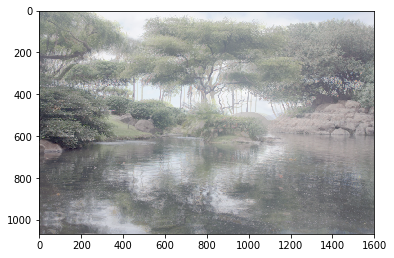

In [129]:
plt.imshow(tone_image)

In [ ]:
# if image  doesnt show up  right
    # 1. play with exponent in gamma compression 
    # 2. play with scale  factors
    # 3. check for Nans